In [2]:
ENV["LD_LIBRARY_PATH"] = ""
using Pkg
using DelimitedFiles
using Distributed
using Distances
using StatsBase 
using Random
using Statistics
using LinearAlgebra
using Distributions
using Plots
using CSV
using DataFrames
using Measures
using StatsPlots
using LaTeXStrings

using Printf
rng = Random.MersenneTwister(1234);

#Plots.default(grid =:false, fontfamily="Computer Modern", legend_background_color=:transparent, 
Plots.default(grid =:false, legend_background_color=:transparent, 
labelfontsize=12, tickfontsize=12, legendfontsize=12, markerstrokewidth=0, ms=5, 
foreground_color_legend = nothing);
include("../src/figure.jl");

In [14]:
q = 5;
NUC = ["-", "A", "C", "G", "T"]
nuc2num = Dict(zip(NUC, collect(1:q)))
dir_in = "../data/HIV/processed/"
dir_out = "../data/HIV/csv/"
dir_seq = "/net/dali/home/barton/kais/paper-MPL-inference-master/src/HIV"
HIV_list = readdlm("../data/HIV/job_file_key.txt");
fkey_CT_Add = "computational_time_efficient-AdditMPL"
fkey_CT_Epis = "computational_time_efficient-EpisMPL"
fkey_selec_Add = "selection_efficient-AdditMPL"
fkey_selec_Epis = "selection_efficient-EpisMPL";

In [10]:
B_set, D_set = [], [] 

@printf("Name\tL\tD=qL\tK\tB\tTime(sec)\tMemory(GB)\n")
for n in 1:length(HIV_list[:,1])
    fname_key = HIV_list[n,2]

    ct_set = readdlm(@sprintf("%s/%s_%s.txt", dir_in, fkey_CT_Epis, fname_key))[:,2] # Elapsed_time -> [1,2], Memory--> [3,2] unit is GB
    fname_seq = @sprintf("%s/%s-poly-seq2state.dat", dir_seq, fname_key)
    B, L = size(readdlm(fname_seq)[:, 3:end])
    K = length(unique(readdlm(fname_seq)[:, 1]))
    CT, Mem = ct_set[1], ct_set[3]
    D = ct_set[4]
    #D = Int(q*L + q^2*L*(L-1)/2)
    @printf("%s\t%d\t%.1e\t%d\t%d\t%.1f\t%.1f\n", fname_key, L, D, K, B, CT, Mem)
    push!(B_set, B); push!(D_set, D)

end;

Name	L	D=qL	K	B	Time(sec)	Memory(GB)
700010040-3	303	1.4e+05	8	82	4.0	0.5
700010040-5	146	3.2e+04	8	74	3.5	0.3
700010058-3	90	1.2e+04	4	25	3.7	0.3
700010058-5	96	1.3e+04	8	52	3.5	0.3
700010077-3	203	6.5e+04	5	44	3.6	0.3
700010077-5	48	3.4e+03	4	32	3.9	0.3
700010470-3	367	2.2e+05	6	113	8.1	0.8
700010470-5	193	5.7e+04	7	104	7.4	0.4
700010607-3	239	8.5e+04	4	73	4.0	0.4
700010607-5	78	9.1e+03	4	76	4.2	0.3
703010131-3	744	8.7e+05	9	114	12.8	2.7
703010131-5	261	9.9e+04	9	76	4.3	0.4
703010159-3	477	3.5e+05	8	98	8.0	1.1
703010159-5	216	7.0e+04	8	93	7.0	0.4
703010256-3	463	3.5e+05	6	99	8.4	1.1
703010256-5	402	2.4e+05	6	110	8.4	0.9
703010505-3	1131	2.5e+06	23	578	177.3	33.3
703010848-3	2694	1.4e+07	31	1205	3427.0	395.5
704010042-3	875	1.3e+06	6	93	12.2	3.2
704010042-5	266	1.1e+05	6	85	4.4	0.5
705010162-3	508	4.0e+05	5	69	5.0	0.9
705010162-5	254	9.6e+04	5	60	4.3	0.4
705010185-3	292	1.3e+05	5	97	7.2	0.6
705010185-5	85	1.1e+04	3	49	4.1	0.3
705010198-3	204	6.3e+04	3	48	4.3	0.3
705010198-5	72	7.8e+03

## Synthesize processed data

In [20]:
myalpha = 0.3
dist_cut = 50
plot_set = []
x_axis_double_mutation, y_axis_double_mutation = [], []
csv_significant_epis_set = []
cor_with_epitope_set, cor_without_epitope_set, seq_id_set = [], [], []
fname_in_temp = []

for n in 1:length(HIV_list[:,1])
    fname_key = HIV_list[n,2];
    csv_epis_temp = CSV.read(@sprintf("%s/epistasis_with_glycan_%s.csv", dir_out, fname_key), DataFrame);
    idx0 = (abs.(csv_epis_temp.HXB2_i - csv_epis_temp.HXB2_j) .<= dist_cut) .&& (abs.(csv_epis_temp.HXB2_i - csv_epis_temp.HXB2_j) .!= 0) #abs.(csv_epis_temp.Δx_tot) .> 0.1 

    # ----- The following lines consider only pairs of mutations occur at different amino acids. 
    n_raw_max = length(csv_epis_temp.mut_AA_fr1_i)
    hxb2_i_fr1, hxb2_j_fr1 = zeros(Int, n_raw_max), zeros(Int, n_raw_max)
    hxb2_i_fr2, hxb2_j_fr2 = zeros(Int, n_raw_max), zeros(Int, n_raw_max)
    hxb2_i_fr3, hxb2_j_fr3 = zeros(Int, n_raw_max), zeros(Int, n_raw_max)
    hxb2_i_fr1[.!ismissing.(csv_epis_temp.mut_AA_fr1_i)] = extract_integer.(csv_epis_temp.mut_AA_fr1_i[.!ismissing.(csv_epis_temp.mut_AA_fr1_i)])
    hxb2_j_fr1[.!ismissing.(csv_epis_temp.mut_AA_fr1_j)] = extract_integer.(csv_epis_temp.mut_AA_fr1_j[.!ismissing.(csv_epis_temp.mut_AA_fr1_j)])
    hxb2_i_fr2[.!ismissing.(csv_epis_temp.mut_AA_fr2_i)] = extract_integer.(csv_epis_temp.mut_AA_fr2_i[.!ismissing.(csv_epis_temp.mut_AA_fr2_i)])
    hxb2_j_fr2[.!ismissing.(csv_epis_temp.mut_AA_fr2_j)] = extract_integer.(csv_epis_temp.mut_AA_fr2_j[.!ismissing.(csv_epis_temp.mut_AA_fr2_j)])
    hxb2_i_fr3[.!ismissing.(csv_epis_temp.mut_AA_fr3_i)] = extract_integer.(csv_epis_temp.mut_AA_fr3_i[.!ismissing.(csv_epis_temp.mut_AA_fr3_i)])
    hxb2_j_fr3[.!ismissing.(csv_epis_temp.mut_AA_fr3_j)] = extract_integer.(csv_epis_temp.mut_AA_fr3_j[.!ismissing.(csv_epis_temp.mut_AA_fr3_j)]);
    idx1 = (hxb2_i_fr1 .!= hxb2_j_fr1) .|| (hxb2_i_fr2 .!= hxb2_j_fr2) .|| (hxb2_i_fr3 .!= hxb2_j_fr3)

    idx2 = (csv_epis_temp.TF_AA_i .!= "-" .&& csv_epis_temp.TF_AA_j .!= "-") .&& (csv_epis_temp.a .!= "-" .&& csv_epis_temp.b .!= "-")
    
    idx = idx0 .&& idx1 .&& idx2
    #idx = idx0 

    if(count(idx)>0)
        csv_epis_short_range = csv_epis_temp[idx, :]
        csv_epis_short_range = copy(csv_epis_short_range[sortperm(csv_epis_short_range.s_MPL, rev=true), :]);
        #idx = csv_epis_short_range.epitope_i .|| csv_epis_short_range.epitope_j;
        idx = csv_epis_short_range.epitope_i .|| csv_epis_short_range.epitope_j;
        
        max_v = maximum(abs.(100*csv_epis_short_range.s_MPL))+1e-3

        yvec1_y = 100*csv_epis_short_range.s_MPL[idx]
        yvec2_y = 100*csv_epis_short_range.s_MPL[.!idx]
        
        yvec1_x = 100 * (csv_epis_short_range.s_MPL_i[idx] + csv_epis_short_range.s_MPL_j[idx])
        yvec2_x = 100 * (csv_epis_short_range.s_MPL_i[.!idx] + csv_epis_short_range.s_MPL_j[.!idx])
    
        cor_with_epitope = cor(100 * (csv_epis_short_range.s_MPL_i + csv_epis_short_range.s_MPL_j), 100*csv_epis_short_range.s_MPL)
        cor_without_epitope = cor(yvec2_x, yvec2_y)
        push!(cor_with_epitope_set, cor_with_epitope)
        push!(cor_without_epitope_set, cor_without_epitope)
        push!(seq_id_set, fname_key)
        
        push!(x_axis_double_mutation, 100*(csv_epis_short_range.s_MPL_i + csv_epis_short_range.s_MPL_j))
        push!(y_axis_double_mutation, 100*csv_epis_short_range.s_MPL)

        idx_temp_signif = 100*abs.(csv_epis_short_range.s_MPL) .> 0.05
        csv_temp_signif = copy(csv_epis_short_range[ idx_temp_signif, : ])
        csv_temp_signif[!, "PID"] = [fname_key for _ in 1:count(idx_temp_signif)]
        
        push!(csv_significant_epis_set, csv_temp_signif)
        
        p1 = Plots.plot(title = fname_key, ylabel=L"$s_{ij}$ (%)", xlabel=L"$s_i+s_j$ (%)", 
            size=(300, 300), bottom_margn=5mm, xrotation=30, legend=:bottomleft)
        
        scatter!(p1, yvec1_x, yvec1_y, c=:purple, alpha=myalpha, label="CTL escape")
        scatter!(p1, yvec2_x, yvec2_y, c=:gray, alpha=myalpha, label="Other")
        push!(plot_set, p1)
        push!(fname_in_temp, fname_key)
    end;
end;

In [34]:
ymin_this, ymax_this = -0.08, 0.03
xmin_this, xmax_this = -5, 5
dist_cut = 50

plot_set_temp = []
x_axis_double_mutation, y_axis_double_mutation = [], []
y_axis_double_mutation_coevo, y_axis_double_mutation_not_coevo = [],[]
csv_significant_epis_set = []
cor_with_epitope_set, cor_without_epitope_set, seq_id_set = [], [], []
name_coev = ["703010505-3", "703010848-3", "cap256-3"]

for n in 1:length(HIV_list[:, 1])
    fname_key = HIV_list[n,2];
    if(fname_key ∉ ["700010077-5", "700010058-5", "700010607-5",  "705010198-5", "cap256-SU-3"]) # exclude individuals that don't have enough epistatic signals
        csv_epis_temp = CSV.read(@sprintf("%s/epistasis_with_glycan_%s.csv", dir_out, fname_key), DataFrame);
        idx0 = (abs.(csv_epis_temp.HXB2_i - csv_epis_temp.HXB2_j) .<= dist_cut) .&& (abs.(csv_epis_temp.HXB2_i - csv_epis_temp.HXB2_j) .!= 0)  #abs.(csv_epis_temp.Δx_tot) .> 0.1 

        # ----- The following lines consider only pairs of mutations occur at different amino acids. 
        n_raw_max = length(csv_epis_temp.mut_AA_fr1_i)
        hxb2_i_fr1, hxb2_j_fr1 = zeros(Int, n_raw_max), zeros(Int, n_raw_max)
        hxb2_i_fr2, hxb2_j_fr2 = zeros(Int, n_raw_max), zeros(Int, n_raw_max)
        hxb2_i_fr3, hxb2_j_fr3 = zeros(Int, n_raw_max), zeros(Int, n_raw_max)
        hxb2_i_fr1[.!ismissing.(csv_epis_temp.mut_AA_fr1_i)] = extract_integer.(csv_epis_temp.mut_AA_fr1_i[.!ismissing.(csv_epis_temp.mut_AA_fr1_i)])
        hxb2_j_fr1[.!ismissing.(csv_epis_temp.mut_AA_fr1_j)] = extract_integer.(csv_epis_temp.mut_AA_fr1_j[.!ismissing.(csv_epis_temp.mut_AA_fr1_j)])
        hxb2_i_fr2[.!ismissing.(csv_epis_temp.mut_AA_fr2_i)] = extract_integer.(csv_epis_temp.mut_AA_fr2_i[.!ismissing.(csv_epis_temp.mut_AA_fr2_i)])
        hxb2_j_fr2[.!ismissing.(csv_epis_temp.mut_AA_fr2_j)] = extract_integer.(csv_epis_temp.mut_AA_fr2_j[.!ismissing.(csv_epis_temp.mut_AA_fr2_j)])
        hxb2_i_fr3[.!ismissing.(csv_epis_temp.mut_AA_fr3_i)] = extract_integer.(csv_epis_temp.mut_AA_fr3_i[.!ismissing.(csv_epis_temp.mut_AA_fr3_i)])
        hxb2_j_fr3[.!ismissing.(csv_epis_temp.mut_AA_fr3_j)] = extract_integer.(csv_epis_temp.mut_AA_fr3_j[.!ismissing.(csv_epis_temp.mut_AA_fr3_j)]);
        idx1 = (hxb2_i_fr1 .!= hxb2_j_fr1) .|| (hxb2_i_fr2 .!= hxb2_j_fr2) .|| (hxb2_i_fr3 .!= hxb2_j_fr3)

        idx2 = (csv_epis_temp.TF_AA_i .!= "-" .&& csv_epis_temp.TF_AA_j .!= "-") .&& (csv_epis_temp.a .!= "-" .&& csv_epis_temp.b .!= "-")        
        idx = idx0 .&& idx1 .&& idx2
        if(count(idx)>0)
            csv_epis_short_range = csv_epis_temp[idx, :]
            csv_epis_short_range = copy(csv_epis_short_range[sortperm(csv_epis_short_range.s_MPL, rev=true), :]);
            idx = csv_epis_short_range.epitope_i .|| csv_epis_short_range.epitope_j;
            
            max_v = maximum(abs.(100*csv_epis_short_range.s_MPL))+1e-3

            yvec1_y = 100*csv_epis_short_range.s_MPL[idx]
            yvec2_y = 100*csv_epis_short_range.s_MPL[.!idx]
            
            yvec1_x = 100 * (csv_epis_short_range.s_MPL_i[idx] + csv_epis_short_range.s_MPL_j[idx])
            yvec2_x = 100 * (csv_epis_short_range.s_MPL_i[.!idx] + csv_epis_short_range.s_MPL_j[.!idx])
            
            cor_with_epitope = cor(100 * (csv_epis_short_range.s_MPL_i + csv_epis_short_range.s_MPL_j), 100*csv_epis_short_range.s_MPL)
            cor_without_epitope = cor(yvec2_x, yvec2_y)
            push!(cor_with_epitope_set, cor_with_epitope)
            push!(cor_without_epitope_set, cor_without_epitope)
            push!(seq_id_set, fname_key)
            
            push!(x_axis_double_mutation, 100*(csv_epis_short_range.s_MPL_i + csv_epis_short_range.s_MPL_j))
            push!(y_axis_double_mutation, 100*csv_epis_short_range.s_MPL)

            if(fname_key ∈ name_coev)
                push!(y_axis_double_mutation_coevo, 100*csv_epis_short_range.s_MPL)
            else
                push!(y_axis_double_mutation_not_coevo, 100*csv_epis_short_range.s_MPL)
            end
                
            idx_temp_signif = 100*abs.(csv_epis_short_range.s_MPL) .> 0.00
            csv_temp_signif = copy(csv_epis_short_range[ idx_temp_signif, : ])
            csv_temp_signif[!, "PID"] = [fname_key for _ in 1:count(idx_temp_signif)]
            
            push!(csv_significant_epis_set, csv_temp_signif)
            
            p1 = Plots.plot(title = fname_key, legend=(0.2, 0.3), 
                size=(300, 300), bottom_margn=1mm,
                xlim = (xmin_this, xmax_this), ylim=(ymin_this, ymax_this), 
                xticks = ([xmin_this, 0, xmax_this], [xmin_this, 0, xmax_this]), 
                yticks = ([ymin_this, 0, ymax_this], [ymin_this, 0, ymax_this]), 
                legend_background_color=:white, 
            )

            if(fname_key ∉["703010505-3", "703010848-3"]) # epitople label of these examples are epitope of antibodies. 
                scatter!(p1, yvec1_x, yvec1_y, c=:purple, alpha=myalpha*1.2, label=" CTL escape")
            else
                scatter!(p1, yvec1_x, yvec1_y, c=:gray, alpha=myalpha*1.2, label=" CTL escape")
            end;
            scatter!(p1, yvec2_x, yvec2_y, c=:gray, alpha=myalpha, label=" Other")
            
            yvec = collect(ymin_this:0.01:ymax_this)
            xvec = collect(xmin_this:0.1:xmax_this)
            Plots.plot!(p1, 0*yvec, yvec, label=:false, linestyle=:dash, c=:black)
            Plots.plot!(p1, xvec, 0*xvec, label=:false, linestyle=:dash, c=:black)

            
            push!(plot_set_temp, p1)
        end;
    end;
end;

In [35]:
plot_set2 = []
axis_single_mutation_with_E, axis_single_mutation_without_E = [], []
for n in 1:29
    fname_key = HIV_list[n,2];
    if(fname_key ∉ ["700010058-3", "700010077-5", "700010607-5",  "705010198-5",  "cap256-3", "cap256-SU-3", "703010505-3", "703010848-3"])
        csv_add_temp = CSV.read(@sprintf("%s/additive_with_glycan_%s.csv", dir_out, fname_key), DataFrame);
        idx = csv_add_temp.epitope #.&& (csv_add_temp.nonsyn_i .> 0)
        
        yvec1_y = 100*csv_add_temp.s_MPL_with_Epis[idx]
        yvec2_y = 100*csv_add_temp.s_MPL_with_Epis[.!idx]
        yvec1_x = 100*csv_add_temp.s_MPL_without_Epis[idx]
        yvec2_x = 100*csv_add_temp.s_MPL_without_Epis[.!idx]
    
        push!(axis_single_mutation_with_E, 100*csv_add_temp.s_MPL_with_Epis )
        push!(axis_single_mutation_without_E, 100*csv_add_temp.s_MPL_without_Epis )
                    
        p1 = Plots.plot(title = fname_key, ylabel=L"$s_{i}$ (%) w Epis", xlabel=L"$s_i$ (%) wo Epis", 
            size=(300, 300), bottom_margn=5mm, xrotation=30)
        
        scatter!(p1, yvec1_x, yvec1_y, c=:purple, alpha=myalpha, label="CTL escape")
        scatter!(p1, yvec2_x, yvec2_y, c=:gray, alpha=myalpha, label="Other")
        push!(plot_set2, p1)
    end
end;

## Fig. 4 and Fig. 5 -- selection and epistatic coefficients for HIV subjects 

In [36]:
my_lw=5

p1_hist_sel = Plots.plot(xlabel=L"Selection coefficient, $s_i$ (%)", ylabel="Counts", legend=(0.55, 0.98), title="Distribution across individuals")
Plots.plot!(p1_hist_sel, [reduce(vcat, axis_single_mutation_without_E)], seriestype=:stephist, label=" Without epistasis", lw=my_lw, c=:gray, alpha=0.5, nbins=30)
Plots.plot!(p1_hist_sel, reduce(vcat, axis_single_mutation_with_E), seriestype=:stephist, label=" Full model", lw=my_lw, c=:green, nbins=30) 

p2_hist_eps = Plots.plot(xlabel=L"Epistatic coefficient, $s_{ij}$ (%)", ylabel="Counts", legend=:false)
plot!(0*collect(1:100:2000), collect(1:100:2000), label=:false, c=:gray, linestyle=:dash)
Plots.plot!(p2_hist_eps, [reduce(vcat, y_axis_double_mutation_not_coevo) ], seriestype=:stephist, lw=my_lw, c=:gray, bottom_margin=5mm, alpha=0.5, nbins=30);
#display(p2_hist_eps);

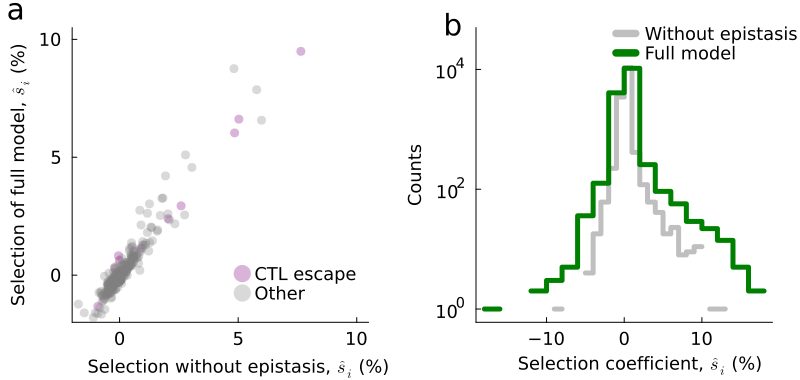

In [42]:
id_PID = 5

ptemp1 = plot(plot_set2[id_PID], xlabel=" ", title="", margin=5mm, xrotation=0,
        xlim=(-2, 10.5), ylim=(-2, 10.5), legend=:bottomright, 
        xticks=([0,5,10]), yticks=([0,5,10]),
        labelfontsize=12, ylabel=L"Selection of full model, $\hat{s}_i$ (%)" )
annotate!(-4.4, 11.3, text("a", :center, :black, 20) )
annotate!(5, -4, text(L"Selection without epistasis, $\hat{s}_i$ (%)", :center, :black, 12) )

ptemp2 = plot(p1_hist_sel, ylim=(0.6, 5e4), yaxis=:log10, yticks=([1,  10^2,  10^4]), xticks=([-10, 0, 10]), title="", xlabel=" ")
annotate!(-22, 5.6*10^4, text("b", :center, :black, 20) )
annotate!(2, 0.11, text(L"Selection coefficient, $\hat{s}_i$ (%)", :center, :black, 12) )

l = @layout[a{0.5w} b{0.5w}]
p_fig_1 = Plots.plot(
    ptemp1, ptemp2,                     
    layout=l, size=(800, 380), margin=5mm);
display(p_fig_1);
#Plots.savefig("../figures/fig_selection.pdf")

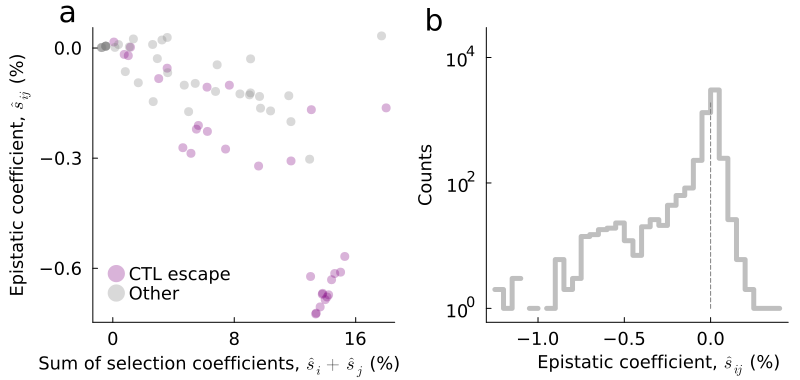

In [56]:
ptemp1 = plot(plot_set[id_PID], xlabel=" ", 
    yticks=([-0.6, -0.3, 0]), xticks=([0, 8, 16]),
    legend=:bottomleft,
)
#annotate!(-3.6, 0.09, text("a", :center, :black, 20) )
annotate!(-3, 0.1, text("a", :center, :black, 20) )
#annotate!(4, -0.85, text(L"Sum of selection coefficients, $\hat{s}_i + \hat{s}_j$ (%)", :center, :black, 12) )
annotate!(7, -0.87, text(L"Sum of selection coefficients, $\hat{s}_i + \hat{s}_j$ (%)", :center, :black, 12) )

ptemp2 = plot(p2_hist_eps, ylim=(0.6, 3e4), yaxis=:log10, yticks=([1, 10^2, 10^4]), 
    xticks=([-1.0, -0.5, 0, 0.5]), title="", xlabel= " " )
annotate!(-1.6, 4*10^4, text("b", :center, :black, 20) )
annotate!(-0.3, 0.12, text(L"Epistatic coefficient, $\hat{s}_{ij}$ (%)", :center, :black, 12) )


l = @layout[a{0.5w} b{0.5w}]
p_fig_3 = Plots.plot(
    plot(ptemp1, title="", margin=5mm, labelfontsize=12, 
        ylabel=L"Epistatic coefficient, $\hat{s}_{ij}$ (%)", 
        ),  xrotation=0, ptemp2, xlabelpad=-10,
    layout=l, bottom_margin=5mm, size=(800, 380) );
display(p_fig_3);
#Plots.savefig("../figures/fig_epistasis.pdf");

### Epistasis versus sum of selection for all cases. 

In [48]:
#dist_cut = 1000000
ymin_this, ymax_this = -1.5, 0.5
xmin_this, xmax_this = -10, 15
dist_cut = 50
plot_set_temp = []
x_axis_double_mutation, y_axis_double_mutation = [], []
y_axis_double_mutation_coevo, y_axis_double_mutation_not_coevo = [],[]
name_coev = ["703010505-3", "703010848-3", "cap256-3"]

csv_significant_epis_set = []
cor_with_epitope_set, cor_without_epitope_set, seq_id_set = [], [], []

for n in 1:length(HIV_list[:, 1])
    fname_key = HIV_list[n,2];
    if(fname_key ∉ ["700010077-5", "700010058-5", "700010607-5",  "705010198-5", "cap256-SU-3"])
        csv_epis_temp = CSV.read(@sprintf("%s/epistasis_with_glycan_%s.csv", dir_out, fname_key), DataFrame);
        idx0 = (abs.(csv_epis_temp.HXB2_i - csv_epis_temp.HXB2_j) .< dist_cut) .&& (abs.(csv_epis_temp.HXB2_i - csv_epis_temp.HXB2_j) .!= 0) 

        # ----- The following lines consider only pairs of mutations occur at different amino acids. 
        n_raw_max = length(csv_epis_temp.mut_AA_fr1_i)
        hxb2_i_fr1, hxb2_j_fr1 = zeros(Int, n_raw_max), zeros(Int, n_raw_max)
        hxb2_i_fr2, hxb2_j_fr2 = zeros(Int, n_raw_max), zeros(Int, n_raw_max)
        hxb2_i_fr3, hxb2_j_fr3 = zeros(Int, n_raw_max), zeros(Int, n_raw_max)
        hxb2_i_fr1[.!ismissing.(csv_epis_temp.mut_AA_fr1_i)] = extract_integer.(csv_epis_temp.mut_AA_fr1_i[.!ismissing.(csv_epis_temp.mut_AA_fr1_i)])
        hxb2_j_fr1[.!ismissing.(csv_epis_temp.mut_AA_fr1_j)] = extract_integer.(csv_epis_temp.mut_AA_fr1_j[.!ismissing.(csv_epis_temp.mut_AA_fr1_j)])
        hxb2_i_fr2[.!ismissing.(csv_epis_temp.mut_AA_fr2_i)] = extract_integer.(csv_epis_temp.mut_AA_fr2_i[.!ismissing.(csv_epis_temp.mut_AA_fr2_i)])
        hxb2_j_fr2[.!ismissing.(csv_epis_temp.mut_AA_fr2_j)] = extract_integer.(csv_epis_temp.mut_AA_fr2_j[.!ismissing.(csv_epis_temp.mut_AA_fr2_j)])
        hxb2_i_fr3[.!ismissing.(csv_epis_temp.mut_AA_fr3_i)] = extract_integer.(csv_epis_temp.mut_AA_fr3_i[.!ismissing.(csv_epis_temp.mut_AA_fr3_i)])
        hxb2_j_fr3[.!ismissing.(csv_epis_temp.mut_AA_fr3_j)] = extract_integer.(csv_epis_temp.mut_AA_fr3_j[.!ismissing.(csv_epis_temp.mut_AA_fr3_j)]);
        idx1 = (hxb2_i_fr1 .!= hxb2_j_fr1) .|| (hxb2_i_fr2 .!= hxb2_j_fr2) .|| (hxb2_i_fr3 .!= hxb2_j_fr3)

        idx2 = (csv_epis_temp.TF_AA_i .!= "-" .&& csv_epis_temp.TF_AA_j .!= "-") .&& (csv_epis_temp.a .!= "-" .&& csv_epis_temp.b .!= "-")
        
        idx = idx0 .&& idx1 .&& idx2

        if(count(idx)>0)
            csv_epis_short_range = csv_epis_temp[idx, :]
            csv_epis_short_range = copy(csv_epis_short_range[sortperm(csv_epis_short_range.s_MPL, rev=true), :]);
            #idx = csv_epis_short_range.epitope_i .|| csv_epis_short_range.epitope_j;
            idx = csv_epis_short_range.epitope_i .|| csv_epis_short_range.epitope_j;
            
            max_v = maximum(abs.(100*csv_epis_short_range.s_MPL))+1e-3

            yvec1_y = 100*csv_epis_short_range.s_MPL[idx]
            yvec2_y = 100*csv_epis_short_range.s_MPL[.!idx]
            
            yvec1_x = 100 * (csv_epis_short_range.s_MPL_i[idx] + csv_epis_short_range.s_MPL_j[idx])
            yvec2_x = 100 * (csv_epis_short_range.s_MPL_i[.!idx] + csv_epis_short_range.s_MPL_j[.!idx])

            cor_with_epitope = cor(100 * (csv_epis_short_range.s_MPL_i + csv_epis_short_range.s_MPL_j), 100*csv_epis_short_range.s_MPL)
            cor_without_epitope = cor(yvec2_x, yvec2_y)
            push!(cor_with_epitope_set, cor_with_epitope)
            push!(cor_without_epitope_set, cor_without_epitope)
            push!(seq_id_set, fname_key)
            
            push!(x_axis_double_mutation, 100*(csv_epis_short_range.s_MPL_i + csv_epis_short_range.s_MPL_j))
            push!(y_axis_double_mutation, 100*csv_epis_short_range.s_MPL)

            if(fname_key ∈ name_coev)
                push!(y_axis_double_mutation_coevo, 100*csv_epis_short_range.s_MPL)
            else
                push!(y_axis_double_mutation_not_coevo, 100*csv_epis_short_range.s_MPL)
            end
                
            idx_temp_signif = 100*abs.(csv_epis_short_range.s_MPL) .> 0.05
            csv_temp_signif = copy(csv_epis_short_range[ idx_temp_signif, : ])
            csv_temp_signif[!, "PID"] = [fname_key for _ in 1:count(idx_temp_signif)]
            
            push!(csv_significant_epis_set, csv_temp_signif)
            
            p1 = Plots.plot(title = fname_key, legend=(0.2, 0.3), 
                size=(300, 300), bottom_margn=1mm,
                legend_background_color=:white, )

            if(fname_key ∉["703010505-3", "703010848-3"]) # epitople label of these examples are epitope of antibodies. 
                scatter!(p1, yvec1_x, yvec1_y, c=:purple, alpha=myalpha*1.2, label=" CTL escape")
            else
                scatter!(p1, yvec1_x, yvec1_y, c=:gray, alpha=myalpha*1.2, label=" CTL escape")
            end;
            scatter!(p1, yvec2_x, yvec2_y, c=:gray, alpha=myalpha, label=" Other")
            
            yvec = collect(ymin_this:0.1:ymax_this)
            xvec = collect(xmin_this:0.1:xmax_this)
            Plots.plot!(p1, 0*yvec, yvec, label=:false, linestyle=:dash, c=:black)
            Plots.plot!(p1, xvec, 0*xvec, label=:false, linestyle=:dash, c=:black)

            push!(plot_set_temp, p1)
        end;
    end;
end;
str_ylabel=text(L"Epistatic coefficient, $\hat{s}_{ij}\ (\%)$", rotation=90, :black, 12)
str_xlabel=text(L"Sum of selection coefficients, $\hat{s}_i + \hat{s}_j\ (\%)$", :center, :black, 12) ;
p_summary = Plots.plot(plot_set_temp..., size=(1200, 1200) );

In [54]:
x_xp, x_yp = 19, -2.3
y_xp, y_yp = -14, -0.5

ymin_this, ymax_this = -1.5, 0.5
xmin_this, xmax_this = -5, 15
xticks_set = [-5, 0, 5, 10, 15]

p1t = plot(p_summary[1], legend=:false, xticks = (xticks_set, [" ", " ", " "]))
#annotate!(y_xp, y_yp, str_ylabel)
p2t = plot(p_summary[2], legend=:false, xticks = (xticks_set, [" ", " ", " "]), yticks = ([ymin_this, 0, ymax_this], [" ", " ", " "]) )
p3t = plot(p_summary[3], legend=:false, xticks = (xticks_set, [" ", " ", " "]), yticks = ([ymin_this, 0, ymax_this], [" ", " ", " "]) )
p4t = plot(p_summary[4], legend=:false, xticks = (xticks_set, [" ", " ", " "]), yticks = ([ymin_this, 0, ymax_this], [" ", " ", " "]) )

p5t = plot(p_summary[5], legend=:false, xticks = (xticks_set, [" ", " ", " "]))
#annotate!(y_xp, y_yp, str_ylabel)
p7t = plot(p_summary[7], legend=:false, xticks = (xticks_set, [" ", " ", " "]), yticks = ([ymin_this, 0, ymax_this], [" ", " ", " "]))
p9t = plot(p_summary[9], legend=:false, xticks = (xticks_set, [" ", " ", " "]), yticks = ([ymin_this, 0, ymax_this], [" ", " ", " "]))
p10t = plot(p_summary[10], legend=:false, xticks = (xticks_set, [" ", " ", " "]), yticks = ([ymin_this, 0, ymax_this], [" ", " ", " "]))

p11t = plot(p_summary[11], legend=:false, xticks = (xticks_set, [" ", " ", " "]))
annotate!(y_xp, y_yp, str_ylabel)
p13t = plot(p_summary[13], legend=:false, xticks = (xticks_set, [" ", " ", " "]), yticks = ([ymin_this, 0, ymax_this], [" ", " ", " "]))
p14t = plot(p_summary[16], legend=:false, xticks = (xticks_set, [" ", " ", " "]), yticks = ([ymin_this, 0, ymax_this], [" ", " ", " "]))
p15t = plot(p_summary[17], legend=:false, xticks = (xticks_set, [" ", " ", " "]), yticks = ([ymin_this, 0, ymax_this], [" ", " ", " "]))

p16t = plot(p_summary[18], legend=:false, xticks = (xticks_set, [" ", " ", " "]))
#annotate!(y_xp, y_yp, str_ylabel);
p17t = plot(p_summary[19], legend=:false, xticks = (xticks_set, [" ", " ", " "]), yticks = ([ymin_this, 0, ymax_this], [" ", " ", " "]))
p18t = plot(p_summary[20], legend=:false, xticks = (xticks_set, [" ", " ", " "]), yticks = ([ymin_this, 0, ymax_this], [" ", " ", " "]))
p19t = plot(p_summary[21], legend=:false , xticks = (xticks_set, [" ", " ", " "]), yticks = ([ymin_this, 0, ymax_this], [" ", " ", " "]))

p21t = plot(p_summary[22])
p22t = plot(p_summary[23], legend=:false, yticks = ([ymin_this, 0, ymax_this], [" ", " ", " "]))
annotate!(x_xp, x_yp, str_xlabel)
p23t = plot(p_summary[24], legend=:false, yticks = ([ymin_this, 0, ymax_this], [" ", " ", " "]))
#annotate!(x_xp, x_yp, str_xlabel)
p24t = plot(p_summary[8], legend=:false, yticks = ([ymin_this, 0, ymax_this], [" ", " ", " "]))
#annotate!(x_xp, x_yp, str_xlabel)

ptemp = plot(size=(900, 1200), bottom_margin=6mm, left_margin=10mm, 
    xlim = (xmin_this, xmax_this), ylim=(ymin_this, ymax_this), 
    xticks = ([xmin_this, 0, xmax_this], [xmin_this, 0, xmax_this]), 
    yticks = ([ymin_this, 0, ymax_this], [ymin_this, 0, ymax_this]), 
    p1t, p2t, p3t, p4t, 
    p5t, p7t, p9t, p10t, 
    p11t, p13t, p14t, p15t, 
    p16t, p17t, p18t, p19t, 
    p21t, p22t, p23t, p24t, 
    layout=(5, 4) );
#display(ptemp)
#Plots.savefig("../figures/sum_selection_vs_epistasis_all.pdf")